# Erweiterung des A*
In diesem Notebook wird die Erweiterung des A* Aufgabe für Aufgabe erklärt und anhand von Beispielen demonstriert.

## Aufgabe 1: Erweiterung des A* Algorithmus
Zuerst definieren wir die Konfiguration für den A* Algorithmus, die wir später verwenden werden. Diese Konfiguration enthält Parameter wie Diskretisierung pro Achse, Gewichtung, Reopening und Kollisionsprüfung der Verbindung.

In [1]:
aStar_config1 = dict()
aStar_config1["w"] = 0.5  # weight for the heuristic
aStar_config1["heuristic"]  = "euclidean"  # heuristic function to use
aStar_config1["reopen"] = False  # whether to allow reopening of nodes
aStar_config1["dof"] = 2  # number of degrees of freedom
aStar_config1["check_connection"] = False  # whether to check for collisions between nodes
aStar_config1["lazy_check_connection"] = True  # only check the connection when node is expanded. We recommend leaving this as True (performance)
aStar_config1["discretization"] = [10, 10]  # number of discretization steps per dof
aStar_config1["benchmark"] = [9]  # benchmark to use, can be a list of indices from the benchmark list

# second config for comparison
import copy
aStar_config2 = copy.deepcopy(aStar_config1)

In [2]:
# import everthing we need for the A* algorithm and visualization
import sys, os, time
sys.path.append(os.path.join(os.getcwd(), 'core'))
sys.path.append(os.path.join(os.getcwd(), 'evaluation/two_dof'))

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from evaluation.two_dof.IPTestSuite_2DoF import benchList
from evaluation.two_dof.PlotEnvironments import visualizeBenchmark
from core.IPAStarExtended import AStar
from core.IPVISAStar import aStarVisualizeIncrementalOpenCV
import matplotlib.pyplot as plt
%matplotlib inline
from Benchmarking import get_config_dir_name, evaluate

### 1. Veränderliche Diskretisierung
**Führen Sie eine veränderliche Diskretisierung ein. In der derzeitigen Implementierung wird sehr rudimentär die Schrittweise 1 angenommen, d.h. werden die Grenzen 0-25 angenommen, entspricht dies 25 Schritten.
Ermöglichen Sie es daher, den gegebenen Bereich in in beliebige zu Beginn einer Planung fest vorgegebene Anzahl von Schritten aufzuteilen, z.B. 0-25 in 100, 221 oder auch 1000 Schritte.
Dabei soll jede Achse des Konfigurationsraums unterschiedlich diskretisierbar sein.**

Zuerst berechnen wir anhand der angegebenen Anzahl Diskretisierungsschritte und der Szenenlimits die Schrittweite entlang jeder Achse `core/IPAStarExtended.py Z.136-141`.
Anschließend benutzen wir die berechnete Schrittweite, um in `_handleNode()` die benachbarten Knoten zu erzeugen `core/IPAStarExtended.py Z.338`.

**Start- und Endwert können eventuell nicht auf diesem Gitter liegen. Wie können Sie dennoch einen kollisionsfreien Pfad von Start zu Ziel realisieren? Implementieren Sie eine geeignete Strategie.**

Durch unsere gewählte Strategie liegt der Startknoten immer auf dem Gitter. Der Endknoten hingegen kann außerhalb des Gitters liegen.
Deshalb überprüfen wir ob wir das Ziel gefunden haben nicht mehr anhand von GLeichheit der Position, sondern überprüfen ob der aktuell expandierte Knoten innerhalb derselben Gridzelle wie das Ziel liegt `core/IPAStarExtended.py Z. 275-281`.
Ist dies der Fall, überprüfen wir, ob die Verbindung zum Knoten kollisionsfrei ist.
Falls ja, wir der Zielknoten an den Pfad angehängt und die Suche beendet `core/IPAStarExtended.py Z. 202-207`.

Die folgende Zelle zeigt ein Beispiel mit niedriger und hoher Diskretisierung. Während die Planung mit hoher Diskretiseung deutlich länger dauert, ist der gefundene Pfad näher am Hindernis und damit kürzer.

Search space explored:   0%|          | 0/100 [00:00<?, ?nodes/s]

Planning with 10 discretization steps per axis took 0.03 seconds


Search space explored:   0%|          | 0/10000 [00:00<?, ?nodes/s]

Planning with 100 discretization steps per axis took 1.01 seconds


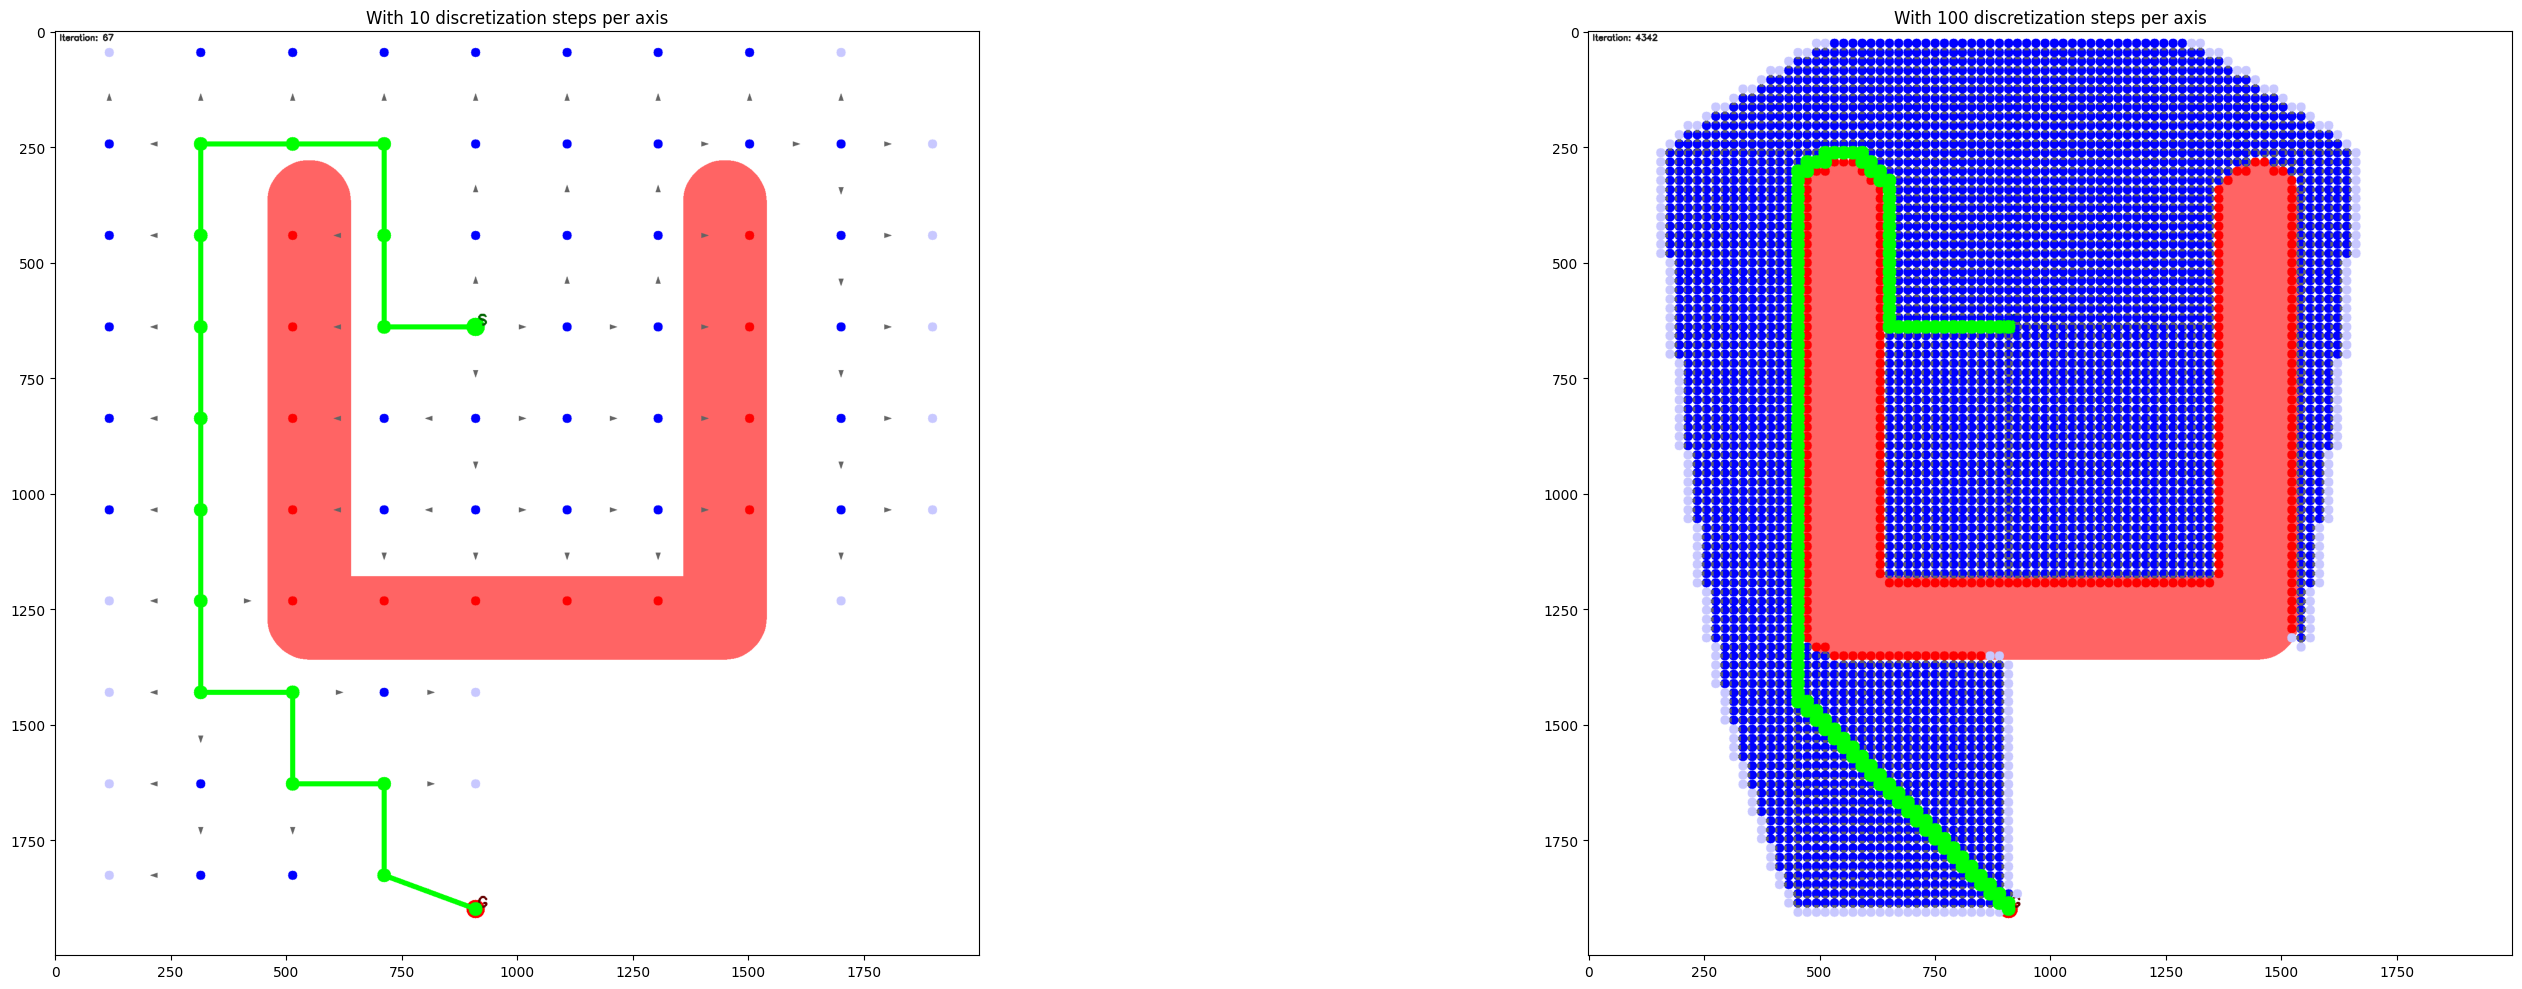

In [3]:
start_time = time.time()
stats1, solution1, deltas1, astar1 = evaluate(config=aStar_config1, benchmark=benchList[aStar_config1["benchmark"][0]], dump=True)
print(f"Planning with 10 discretization steps per axis took {time.time() - start_time:.2f} seconds")

fig = plt.figure(figsize=(35,10))
ax1 = fig.add_subplot(1, 2, 1)
aStarVisualizeIncrementalOpenCV(planner=astar1, solution=solution1, deltas=deltas1, ax=ax1, plot_matplotlib=True)
ax1.set_title("With 10 discretization steps per axis")

aStar_config2["discretization"] = [100, 100]  # increase discretization to 100 steps per axis
start_time = time.time()
stats2, solution2, deltas2, astar2 = evaluate(config=aStar_config2, benchmark=benchList[aStar_config2["benchmark"][0]], dump=True)
print(f"Planning with 100 discretization steps per axis took {time.time() - start_time:.2f} seconds")

ax2 = fig.add_subplot(1, 2, 2)
aStarVisualizeIncrementalOpenCV(planner=astar2, solution=solution2, deltas=deltas2, ax=ax2, plot_matplotlib=True)
ax2.set_title("With 100 discretization steps per axis")

plt.tight_layout()
plt.show()

**Derzeit wird nur der Knoten auf Kollision überprüft. Realisieren Sie die Möglichkeit per Konfiguration einzuschalten, dass auch die Verbindung zwischen zwei Knoten auf Kollision überprüft wird.**

Die Kollisionsüberprüfung der Verbindung zwischen zwei Knoten kann durch Setzen des Parameters `check_connection` in der Config auf `True` aktiviert werden.
Eine erste naive Idee war es, die Kollisionsüberprüfung vor dem Einfügen in die OpenList durchzuführen `core/IPAStarExtended.py Z. 342-344`.
Dies ist allerdings nicht sinnvoll, da wir die sehr teure Kollisionsüberprüfung für Knoten durchführen, die wir eventuell nie expandieren.

Deshalb haben wir den zweiten Parameter `lazy_check_connection` eingeführt, der es ermöglicht, die Kollisionsüberprüfung der Verbindung erst dann durchzuführen, wenn der Knoten expandiert wird `core/IPAStarExtended.py Z. 180-188`.
Da der Knoten hier bereits in der OpenList ist, reparieren wir den Knoten, falls die Verbindung zum Father in Kollision ist.
Dazu betrachten wir alle anderen Nachbarn, die bereits closed sind, und prüfen, ob eine Verbindung zu einem dieser Knoten kollisionsfrei ist.
Falls ja, wird der Knoten repariert und die Verbindung zum Father aktualisiert `core/IPAStarExtended.py Z. 221-259`.
Falls nein, setzen wir den Knoten auf unendlich `core/IPAStarExtended.py Z. 188`. Eventuell findet also später Reopening statt.

Das folgende Beispiel zeigt die Auswirkungen der Kollisionsüberprüfung der Verbindung zwischen zwei Knoten. Knoten in Verbindungskollision sind gelb markiert. Auf niedriger Diskretisierung kann durch Kollisionsüberprüfung der Verbindung Kollision vermieden werden, aber die Suchzeit steigt deutlich an.

Search space explored:   0%|          | 0/25 [00:00<?, ?nodes/s]

Planning without line collision check took 0.02 seconds


Search space explored:   0%|          | 0/25 [00:00<?, ?nodes/s]

Planning with line collision check took 0.04 seconds


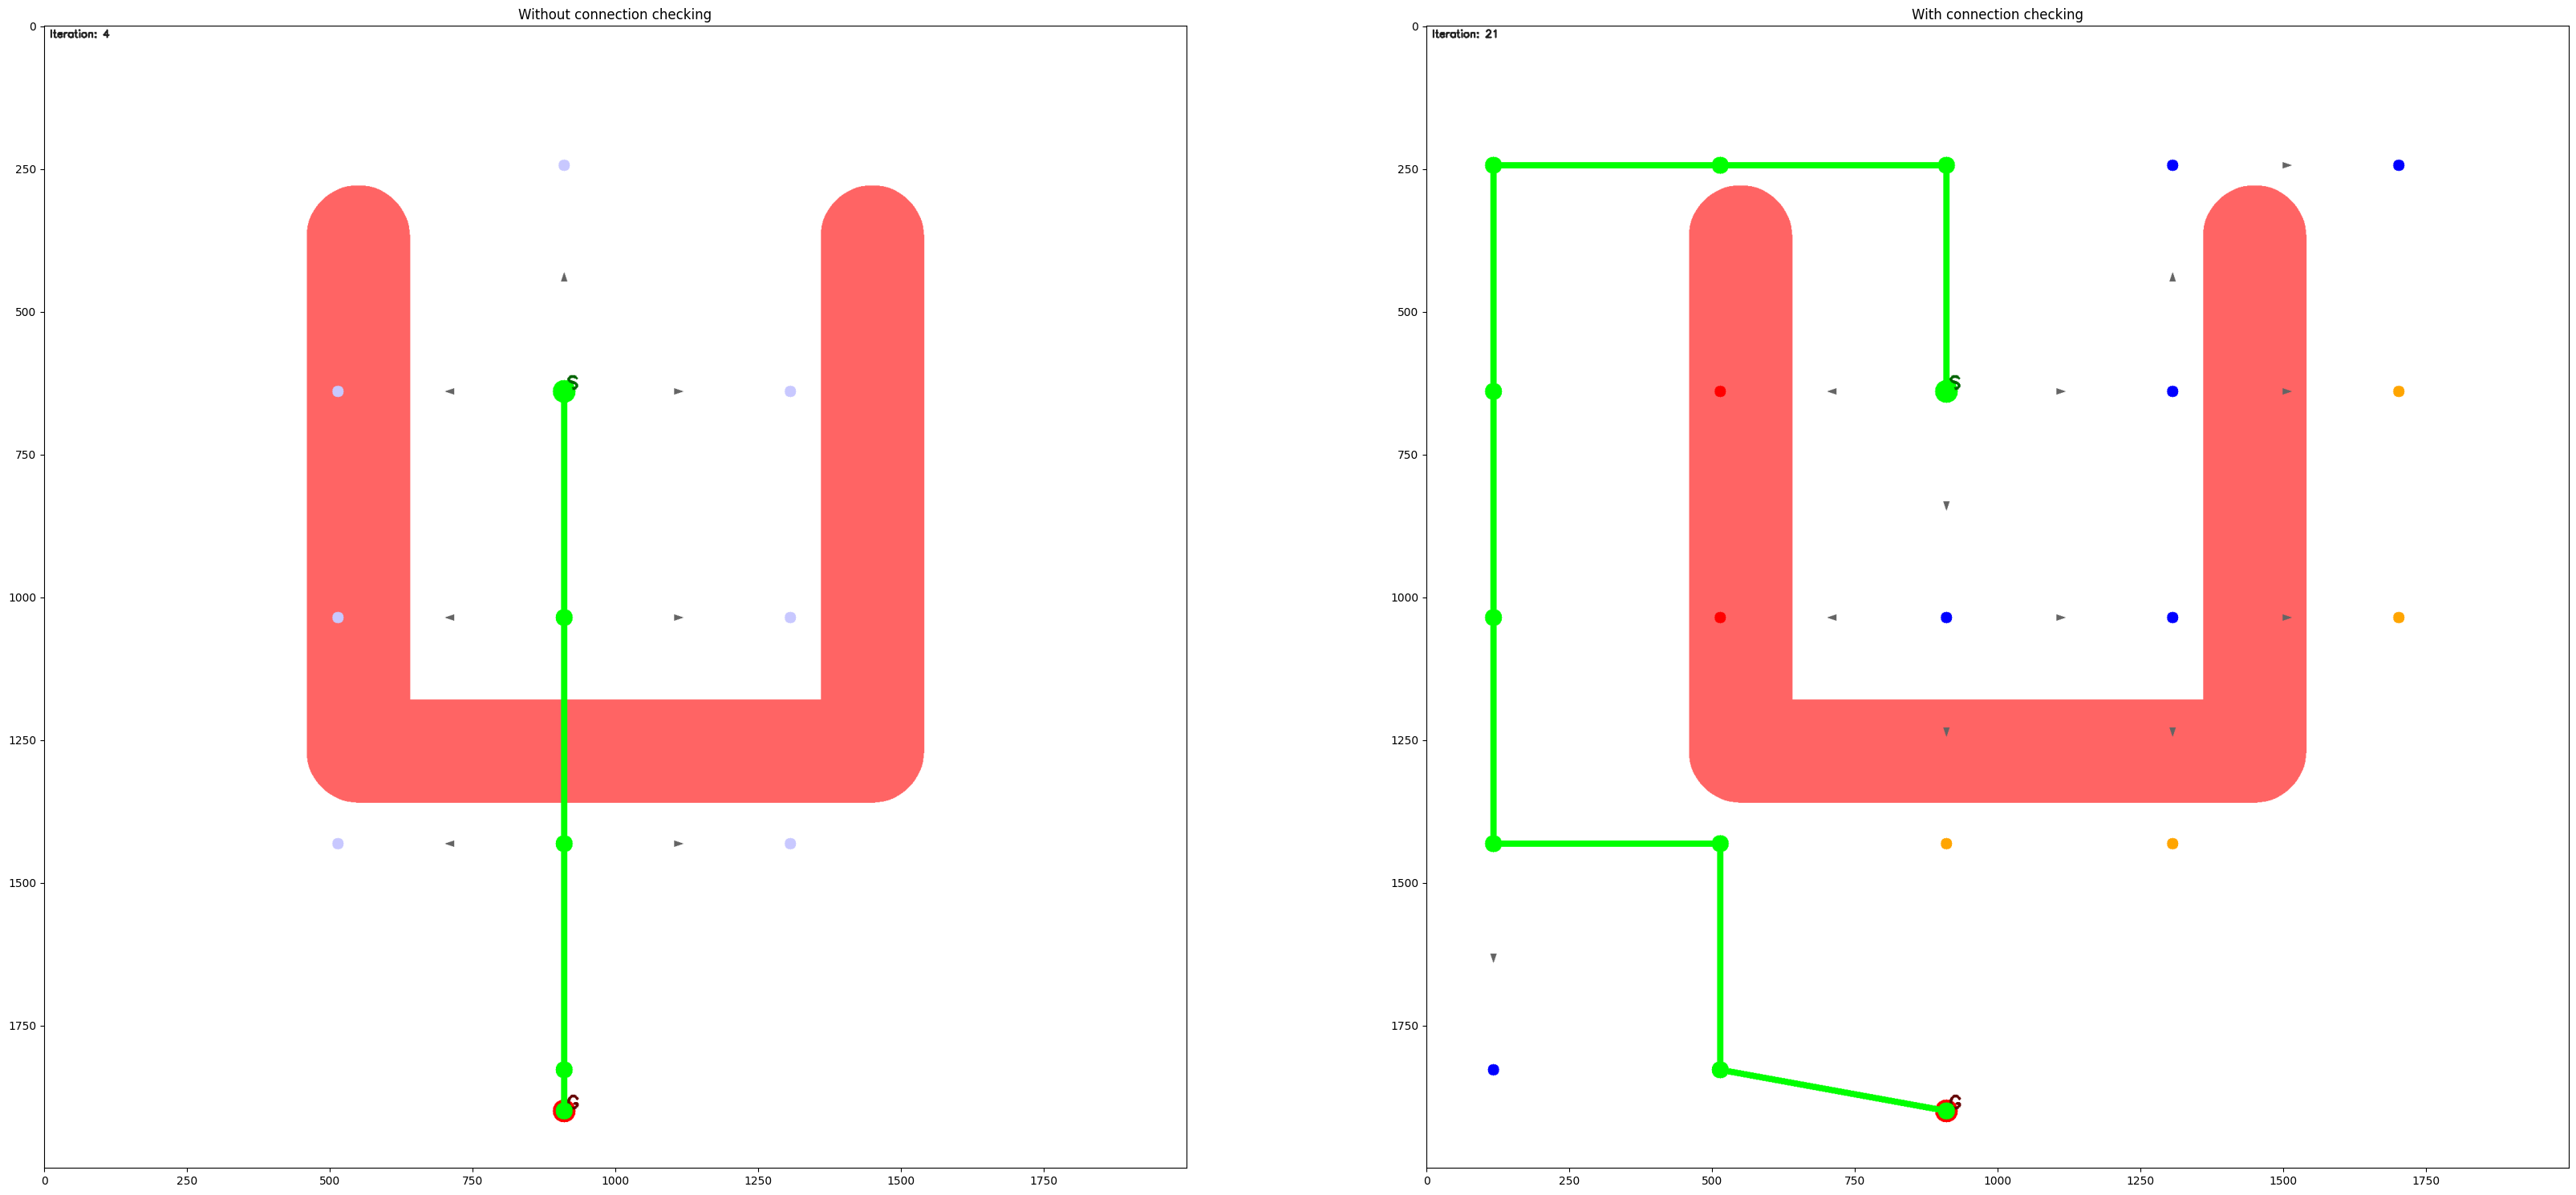

In [4]:
aStar_config1["discretization"] = [5, 5]
start_time = time.time()
stats1, solution1, deltas1, astar1 = evaluate(config=aStar_config1, benchmark=benchList[aStar_config1["benchmark"][0]], dump=True)
print(f"Planning without line collision check took {time.time() - start_time:.2f} seconds")

fig = plt.figure(figsize=(35,15))
ax1 = fig.add_subplot(1, 2, 1)
aStarVisualizeIncrementalOpenCV(planner=astar1, solution=solution1, deltas=deltas1, ax=ax1, plot_matplotlib=True)
ax1.set_title("Without connection checking")

aStar_config2["discretization"] = [5, 5]
aStar_config2["check_connection"] = True  # enable connection checking
start_time = time.time()
stats2, solution2, deltas2, astar2 = evaluate(config=aStar_config2, benchmark=benchList[aStar_config2["benchmark"][0]], dump=True)
print(f"Planning with line collision check took {time.time() - start_time:.2f} seconds")

ax2 = fig.add_subplot(1, 2, 2)
aStarVisualizeIncrementalOpenCV(planner=astar2, solution=solution2, deltas=deltas2, ax=ax2, plot_matplotlib=True)
ax2.set_title("With connection checking")

plt.tight_layout()
plt.show()

### 2. Konfigurierbares Reopening
**Derzeit führt der A\* kein Reopening durch. Machen Sie konfigurierbar, ob Reopening verwendet oder nicht verwendet werden soll.**

Reopening kann durch Setzen des Parameters `reopening` in der Config auf `True` aktiviert werden.
Reopening wird in der Methode `_handleNode()` durchgeführt `core/IPAStarExtended.py Z. 351 - 366`.
Hier wird überprüft, ob der Knoten bereits in der OpenList ist und ob der neue Pfad zu diesem Knoten kürzer ist als der bisherige Pfad.
Falls ja, werden die Kosten des Knoten aktualisiert. Insbesondere muss der Knoten aus der OpenList entfernt und wieder hinzugefügt werden, was relativ teuer ist `core/IPAStarExtended Z. 308 - 312`.

Das folgende Beispiel zeigt die Auswirkungen von Reopening. Rot markierte Pfeile symbolisieren Kanten, die durch Reopening entfernt wurden. Im rechten Bild ist der Pfad minimal kürzer, da Reopening verwendet wird. Allerdings wurden beinahe die Hälfte der Knoten reopened, was insbesondere in höheren Dimensionen zu einem deutlichen Anstieg der Suchzeit führen kann.

Search space explored:   0%|          | 0/2500 [00:00<?, ?nodes/s]

Planning without reopening took 0.14 seconds


Search space explored:   0%|          | 0/2500 [00:00<?, ?nodes/s]

Planning with reopening took 0.15 seconds


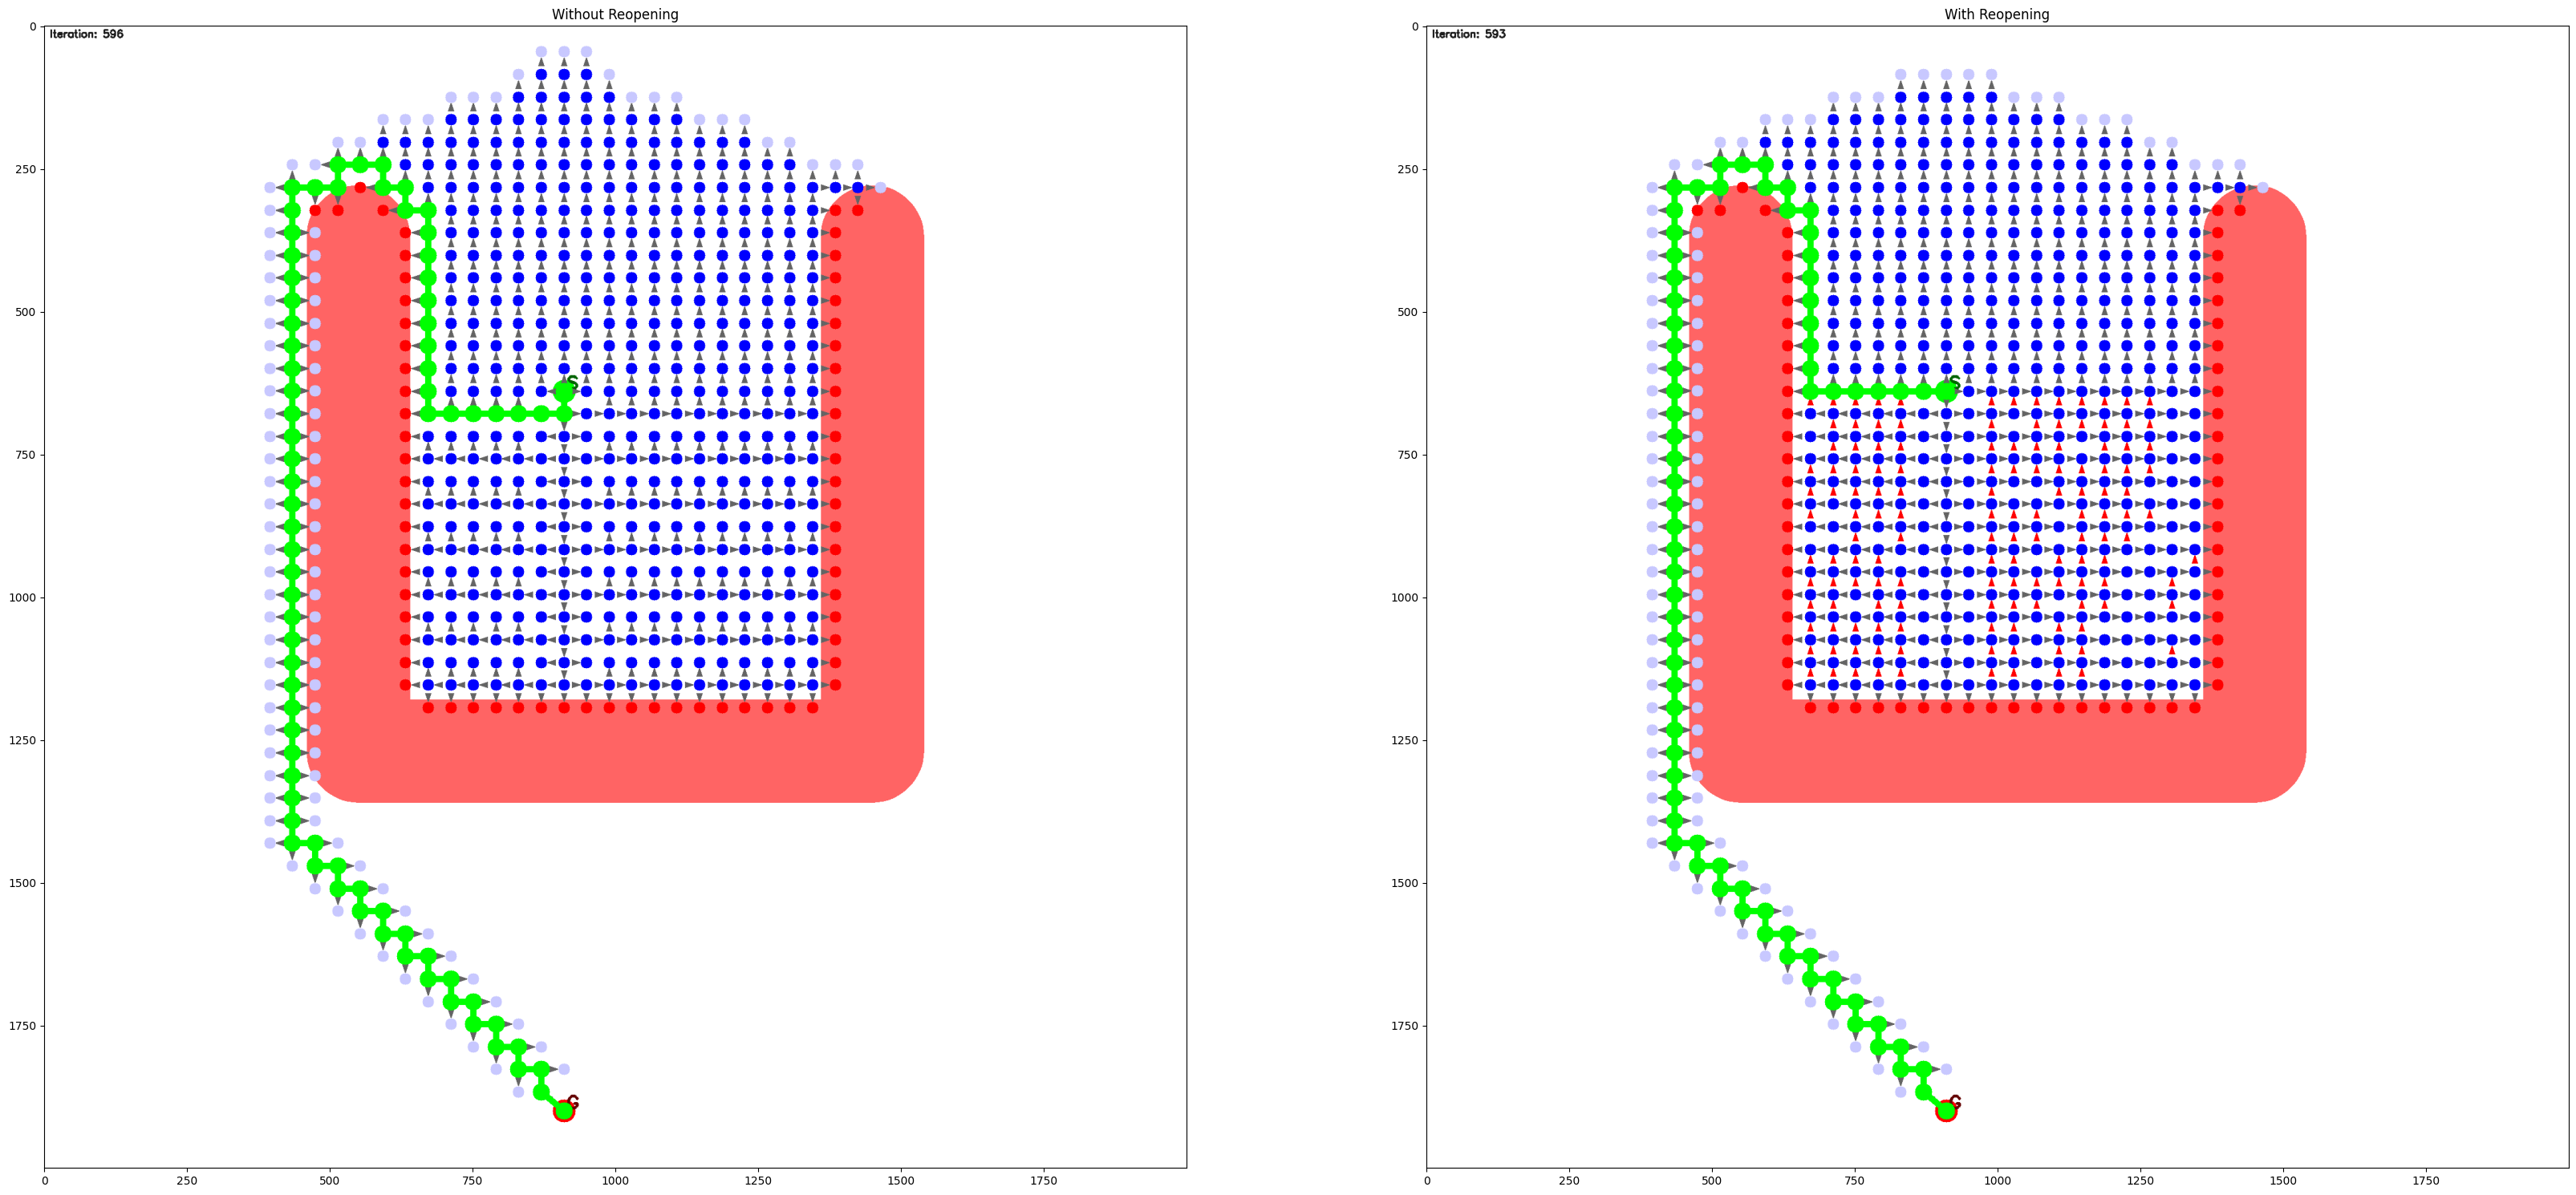

In [5]:
aStar_config1["discretization"] = [50, 50]
aStar_config1["w"] = 0.75
start_time = time.time()
stats1, solution1, deltas1, astar1 = evaluate(config=aStar_config1, benchmark=benchList[aStar_config1["benchmark"][0]], dump=True)
print(f"Planning without reopening took {time.time() - start_time:.2f} seconds")

fig = plt.figure(figsize=(35,15))
ax1 = fig.add_subplot(1, 2, 1)
aStarVisualizeIncrementalOpenCV(planner=astar1, solution=solution1, deltas=deltas1, ax=ax1, plot_matplotlib=True)
ax1.set_title("Without Reopening")

aStar_config2["discretization"] = [50, 50]
aStar_config2["check_connection"] = False
aStar_config2["reopen"] = True
aStar_config2["w"] = 0.75
start_time = time.time()
stats2, solution2, deltas2, astar2 = evaluate(config=aStar_config2, benchmark=benchList[aStar_config2["benchmark"][0]], dump=True)
print(f"Planning with reopening took {time.time() - start_time:.2f} seconds")

ax2 = fig.add_subplot(1, 2, 2)
aStarVisualizeIncrementalOpenCV(planner=astar2, solution=solution2, deltas=deltas2, ax=ax2, plot_matplotlib=True)
ax2.set_title("With Reopening")

plt.tight_layout()
plt.show()

### 3. Vergleich anhand von 5 2-DoF-Benchmarks

**Zeigen Sie die Ergebnisse grafisch und diskutieren Sie im Anschluss.
Die Variationen und Kriterien sind frei kombinierbar.**

| Variationen                     |  Metriken    |
|---------------------------------|--------------|
| # Diskretisierungsschritte      | Suchzeit     |
| Kollision der Verbindung an/aus | Größe Roadmap |
| Gewichtungsfaktor w             | Anzahl Punkte im Pfad |
| Reopening an/aus                | Länge des Pfades |

Siehe Notebook `AStar_benchmark_point.ipynb` für die Visualisierung und Auswertung der Benchmarks.

### 4. Vergleich anhand von 3 Planar-Benchmarks

**Kollisionsüberprüfung der Verbindung soll immer an sein.
Zeigen Sie die Ergebnisse grafisch und diskutieren Sie im Anschluss.
Die Variationen und Kriterien sind frei kombinierbar.**

| Variationen                | Metriken              |
|----------------------------|-----------------------|
| # Freiheitsgrade           | Suchzeit              |
| # Diskretisierungsschritte | Größe Roadmap         |
| Gewichtungsfaktor w        | Anzahl Punkte im Pfad |
| Reopening an/aus           | Länge des Pfades      |

Siehe Notebook `AStar_benchmark_planar.ipynb` für die Visualisierung und Auswertung der Benchmarks.

### 5. Vergleich mit LazyPRM
**Vergleichen Sie die Benchmark Umgebungen aus 4. mit LazyPRM. Wählen Sie geeignete Kriterien, stellen Sie die Ergebnisse grafisch dar und diskutieren Sie diese.**

Siehe Notebook `AStar_benchmark_planar.ipynb` für die Visualisierung und Auswertung der Benchmarks.

### 6. Erzeugen Sie die Animation der Suche in jedem Schritt des A*, die es ermöglicht im 2-DoF Fall das Verhalten exakt nachzuvollziehen.

Da die ursprüngliche Animation der Ergebnisse in Matplotlib ca. 2 Sekunden pro Frame benötigt, haben wir die schrittweise Visualisierung mit OpenCV implementiert.
Hierbei wird innerhalb kurzer Zeit jeder Schritt als jpg-Datei gespeichert, die anschließend zu einem Video zusammengefügt werden kann.
Die Implementierung befindet sich in `core/IPVISAStar.py Z. 502`.
Um nicht immer den gesamten Graph speichen zu müssen, wird nur pro Schritt im A* nur ein delta gespeichert `core/IPAStarExtended.py Z. 59`.

Ein Beispiel der schrittweisen Visualisierung ist im Notebook `AStar_extension_interactive.ipynb` zu finden.


## Aufgabe 2: Weitere Erläuterungen
### 1. Bewegungsbefehle
**Mit welchen Bewegungsbefehlen würden Sie den Ergebnispfad des A\* in ein Roboterprogramm umwandeln? Erläutern Sie, warum das zwar möglich, aber nicht unbedingt sinnvoll ist.**

Der Ergebnispfad des A* Algorithmus besteht aus einer Reihe von diskreten Konfigurationen auf einem Grid, die der Roboter nacheinander anfahren soll.
Dies kann beispielsweise durch lineare Interpolation zwischen den Konfigurationen realisiert werden, wobei der Roboter in jedem Schritt eine neue Konfiguration ansteuert.
Dies ist allerdings nicht unbedingt sinnvoll: Einerseits würde durch abrupte Richtungsänderungen ruckartige Bewegungen entstehen.
Durch die konstanten Starts und Stops würde der Roboter zudem unnötig Zeit verlieren, da er in jedem Schritt zum Stillstand kommen und dann wieder beschleunigen müsste.
Verstärkt wird dieser Umstand noch, wenn keine Diagonalbewegungen erlaubt sind, da der Roboter dann nur einen Gelenkwinkel auf einmal ändern kann.

### 2. Praktische Anwendung
**Was müssen Sie machen, damit er sinnvoll abgefahren werden kann? Erläutern Sie die Vorgehensweise (nicht programmieren).**

Um den Ergebnispfad des A* Algorithmus sinnvoll abfahren zu können, müssen mehrere Schritte unternommen werden:
1. **Smoothing**: Wie in der Vorlesung / den Vorträgen besprochen, würde der von A* geplante Pfad stark von Smoothing profitieren. Durch die kleinschrittige Planung auf dem Grid verfügt der Pfad über viele unnötige Wegpunkte.
Durch Smoothing werden zum einen redundante Wegpunkte auf geraden Strecken entfernt, und eventuelle abrupte Richtungsänderungen minimiert.
2. **Blending**: Nach dem Smoothing bleibt eine reduzierte Anzahl diskreter Konfigurationen mit abrupten Übergängen.
Um nicht nur die diskreten Konfigurationen abzufahren, sondern auch die Zwischenräume zu nutzen, kann Blending zwischen den Konfigurationen durchgeführt werden.
Dies kann beispielsweise durch Parabolisches Blending oder Splines geschehen, um eine glattere Bewegung zu erzeugen. Jedoch muss hierbei die Kollisionsfreiheit gewährleistet werde, insbesondere da optimale Pfade häufig sehr nah an Hindernissen liegen.